In [165]:
import pandas as pd
import numpy as np
import scipy.stats as sts
import seaborn as sns

In [353]:
df = pd.read_csv('/Users/artemarhipov/Downloads/churn_dataset.csv')

# Data Observing

In [354]:
df.head()

,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,ovrrev_Mean,vceovr_Mean,datovr_Mean,roam_Mean,change_mou,...,forgntvl,ethnic,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd,eqpdays,Customer_ID
0,23.9975,219.25,22.500,0.2475,0.00,0.0,0.0,0.0,0.0,-157.25,...,0.0,N,U,U,U,U,U,Y,361.0,1000001
1,57.4925,482.75,37.425,0.2475,22.75,9.1,9.1,0.0,0.0,532.25,...,0.0,Z,U,U,U,U,U,Y,240.0,1000002
2,16.9900,10.25,16.990,0.0000,0.00,0.0,0.0,0.0,0.0,-4.25,...,0.0,N,U,Y,U,U,U,Y,1504.0,1000003
3,38.0000,7.50,38.000,0.0000,0.00,0.0,0.0,0.0,0.0,-1.50,...,0.0,U,Y,U,U,U,U,Y,1812.0,1000004
4,55.2300,570.50,71.980,0.0000,0.00,0.0,0.0,0.0,0.0,38.50,...,0.0,I,U,U,U,U,U,Y,434.0,1000005


In [64]:
print('count strs:', df.shape[0], ',count columns:',df.shape[1])

count strs: 100000 ,count columns: 100


### Посмотрим на таргет (churn)

In [65]:
df.churn.isna().sum() # пустых значений целевой переменной нет

0

#### Перекоса классов в таргете нет, бинарная классификация -> для валидации можем использовать accuracy, однако очевидно, что мы не можем находить всех уходящих в отток клиентов и только их. Но, определив стратегию и ресурс для удержания клиентов, мы можем подобрать нужные пороги по precision и recall. Например, можно сосредоточиться на удержании только высокодоходных клиентов или тех, кто уйдет с большей вероятностью, так как мы ограничены в ресурсах колл-центра, например 

In [67]:
print('записей 1 класса:',df.churn.sum(), ',нулевого:', df.shape[0] - df.churn.sum())

записей 1 класса: 49562 ,нулевого: 50438


### Типы данных в столбцах

In [100]:
df.dtypes.value_counts()

float64    69
object     21
int64      10
dtype: int64

In [103]:
df.select_dtypes(include=['object']).columns

Index(['new_cell', 'crclscod', 'asl_flag', 'prizm_social_one', 'area',
       'dualband', 'refurb_new', 'hnd_webcap', 'ownrent', 'dwlltype',
       'marital', 'infobase', 'HHstatin', 'dwllsize', 'ethnic', 'kid0_2',
       'kid3_5', 'kid6_10', 'kid11_15', 'kid16_17', 'creditcd'],
      dtype='object')

In [114]:
df.select_dtypes(include=['object']).head(1)

,new_cell,crclscod,asl_flag,prizm_social_one,area,dualband,refurb_new,hnd_webcap,ownrent,dwlltype,...,infobase,HHstatin,dwllsize,ethnic,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd
0,U,A,N,S,NORTHWEST/ROCKY MOUNTAIN AREA,Y,N,WCMB,O,S,...,M,C,A,N,U,U,U,U,U,Y


### Количество пропусков в столбцах

<AxesSubplot:>

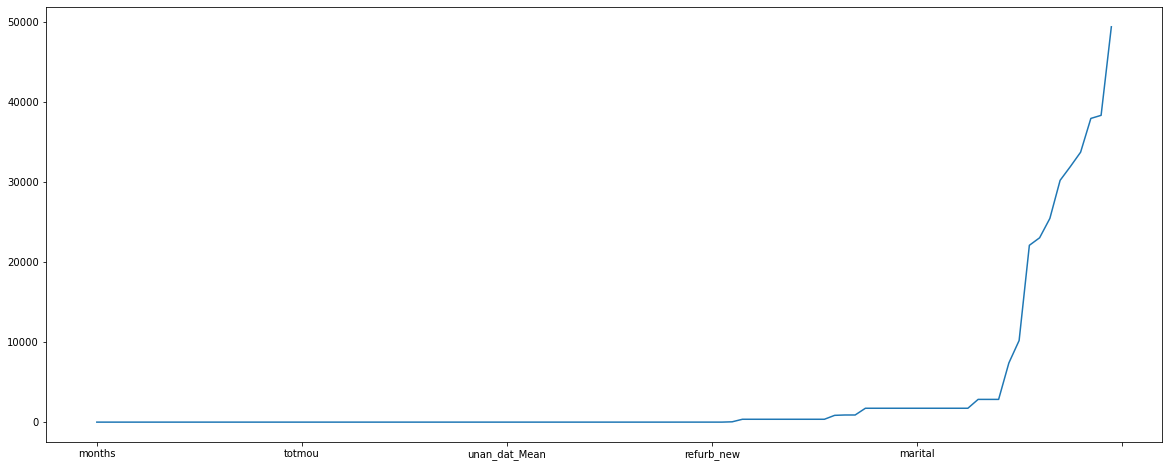

In [111]:
df.isna().sum().sort_values().plot(figsize = (20,8))

#### Видно, что ~11 столбцов относительно пустые 

In [112]:
df.isna().sum().sort_values(ascending=False).head(15)

numbcars            49366
dwllsize            38308
HHstatin            37923
ownrent             33706
dwlltype            31909
lor                 30190
income              25436
adults              23019
infobase            22079
hnd_webcap          10189
prizm_social_one     7388
avg6rev              2839
avg6mou              2839
avg6qty              2839
ethnic               1732
dtype: int64

#### Подавляющее число признаков в датафрейме - категориальные

<AxesSubplot:>

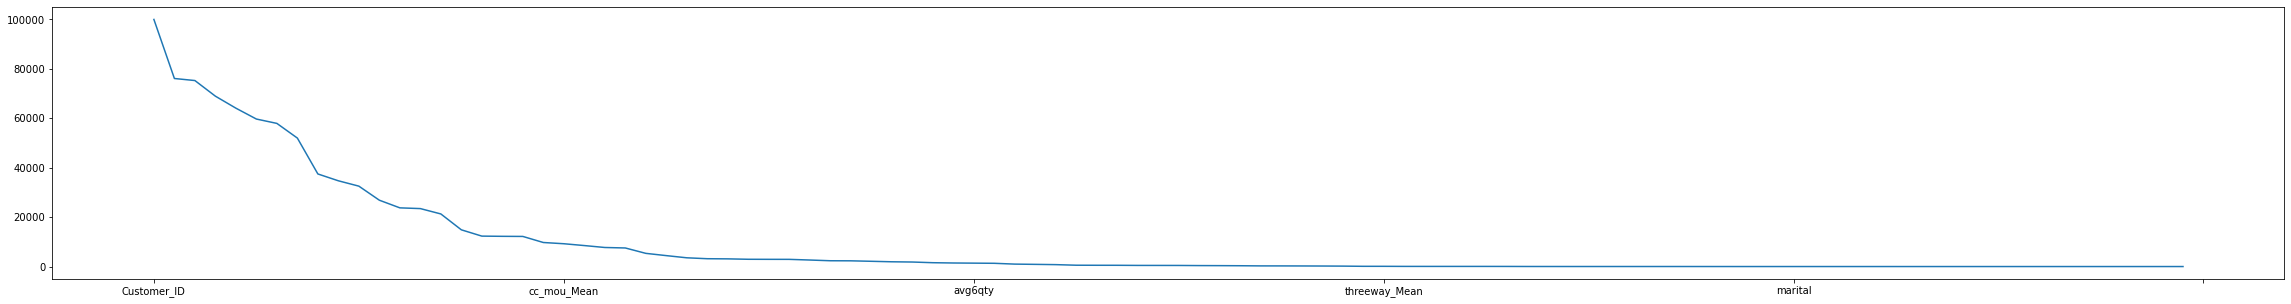

In [120]:
df.nunique().sort_values(ascending=False).plot(figsize = (40,5))

# Отбор признаков
### В имеющихся условиях считаю уместным на начальном этапе отобрать лишь те признаки, которые единолично оказывают наибольшее влияние на цедевую переменную

#### Проведем для каждого признака тест Крускела, проверяющий нулевую гипотезу о равенстве средних выборок
#### Уровень значимости предлагаю взять = 0.01

In [355]:
statistic_results = {}
for i in df.columns:
    result = sts.kruskal(list(df[df.churn == 1][i]),\
                   list(df[df.churn == 0][i]), nan_policy = 'omit')[1]
    if result < 0.01 and i != 'churn' and i != 'Customer_ID':
        statistic_results[i] = result

#### Получили признаки, для значений которых была принята альтернативная гипотеза

In [356]:
print('Отобрано признаков:', len(statistic_results))
statistic_results

Отобрано признаков: 79


{'rev_Mean': 1.5837167952171508e-16,
 'mou_Mean': 2.2828922990841833e-103,
 'totmrc_Mean': 1.1670467318767612e-119,
 'da_Mean': 2.7459259629256845e-13,
 'ovrmou_Mean': 1.2671746508550341e-11,
 'ovrrev_Mean': 2.0215714979657393e-11,
 'vceovr_Mean': 2.1365376550111106e-16,
 'datovr_Mean': 2.1191668408262245e-13,
 'change_mou': 6.058368237588311e-59,
 'drop_vce_Mean': 1.177446700798341e-13,
 'drop_dat_Mean': 0.005229322407504049,
 'blck_vce_Mean': 1.8109254172695666e-19,
 'blck_dat_Mean': 1.0842960847185142e-05,
 'unan_vce_Mean': 4.160194279463955e-55,
 'unan_dat_Mean': 1.821054373332791e-06,
 'plcd_vce_Mean': 4.85817093871339e-75,
 'plcd_dat_Mean': 1.6335269119432372e-24,
 'recv_vce_Mean': 8.151923096575311e-53,
 'comp_vce_Mean': 5.398887689344683e-84,
 'comp_dat_Mean': 7.025020614896038e-19,
 'custcare_Mean': 5.949373674334574e-70,
 'ccrndmou_Mean': 2.134578717738037e-66,
 'cc_mou_Mean': 1.4133371695704369e-64,
 'inonemin_Mean': 2.372206530143368e-44,
 'threeway_Mean': 3.576692465549778

#### Заметим, что, например, признак с названием "eqpdays" выбивается из всех со значением 0. Посмотрим почему

<AxesSubplot:>

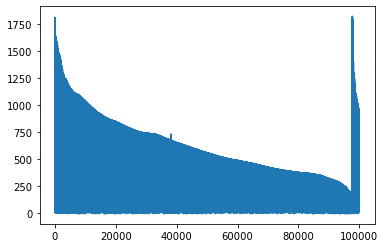

In [176]:
df[df.churn == 0].eqpdays.plot()

In [180]:
df[df.churn == 0].eqpdays.describe()

count    50437.000000
mean       363.280925
std        249.986138
min         -5.000000
25%        196.000000
50%        310.000000
75%        492.000000
max       1823.000000
Name: eqpdays, dtype: float64

#### Визуально на графиках заметно, что "спуск" при таргете = 1 более пологий и в среднем больше по значениям -> получается такая сильная разница в выборочном среднем при, как кажется, одинаковом виде распределении.

<AxesSubplot:>

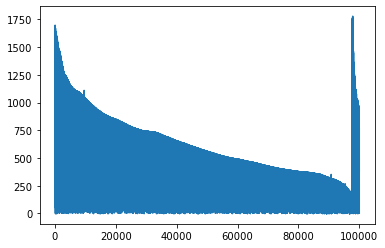

In [177]:
df[df.churn == 1].eqpdays.plot()

In [181]:
df[df.churn == 1].eqpdays.describe()

count    49562.000000
mean       421.089524
std        259.705607
min         -4.000000
25%        245.000000
50%        366.000000
75%        566.000000
max       1779.000000
Name: eqpdays, dtype: float64

#### Для признака hnd_price с аналогично малым значением p-value получим следующее:
#### Аналагочино визуальный анализ не дает качественной интерпретации, "видимого" разделения на классы

<AxesSubplot:>

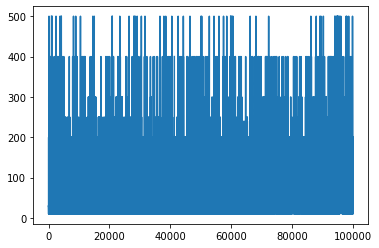

In [324]:
df.hnd_price.plot()

In [322]:
df[df.churn == 0].hnd_price.describe()

count    49902.000000
mean       108.129344
std         61.123188
min          9.989998
25%         59.989990
50%        129.989990
75%        149.989990
max        499.989990
Name: hnd_price, dtype: float64

In [323]:
df[df.churn == 1].hnd_price.describe()

count    49251.000000
mean        95.539523
std         60.228330
min          9.989998
25%         29.989990
50%         99.989990
75%        149.989990
max        499.989990
Name: hnd_price, dtype: float64

#### Посмотрим на категориальные признаки, которые мы отобрали

In [357]:
cat_features = []
for i in statistic_results.keys():
    if i in df.select_dtypes(include=['object']).columns:
        cat_features.append([i,statistic_results[i]])

In [358]:
cat_features

[['crclscod', 9.14479616266583e-47],
 ['asl_flag', 5.66510819341668e-107],
 ['area', 3.4863731913341774e-06],
 ['dualband', 1.2631820105200244e-24],
 ['refurb_new', 1.000339485404885e-23],
 ['ownrent', 2.093635495882403e-12],
 ['dwlltype', 8.973912442377355e-06],
 ['marital', 2.5527869037959576e-07],
 ['infobase', 1.4262838703498428e-14],
 ['HHstatin', 3.732206095824599e-09],
 ['dwllsize', 5.2940757074372294e-14],
 ['ethnic', 2.393809818212552e-10],
 ['creditcd', 4.905011632099304e-08]]

#### Помотрим на признак asl_flag

In [192]:
df.asl_flag.value_counts()

N    86064
Y    13936
Name: asl_flag, dtype: int64

In [193]:
df.groupby(['churn','asl_flag']).agg({'Customer_ID':'count'})

Customer_ID
churn asl_flag             
0     N               42206
      Y                8232
1     N               43858
      Y                5704

#### Полученные данные явным образом не отображают закономерностей, вызванных влиянием целевого признака на остальные

#### Преобразуем категориальные признаки типа object в численные

In [380]:
without_obj_feat_df = df.copy()
for i in df.select_dtypes(include=['object']).columns:
    uniques = df[i].unique()
    dictionary = {}
    for j in range(len(uniques)):
        dictionary[uniques[j]] = str(j)
    #print(dictionary)
    without_obj_feat_df[i] = df[i].map(dictionary).astype(float)   

In [378]:
without_obj_feat_df.head()

,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,ovrrev_Mean,vceovr_Mean,datovr_Mean,roam_Mean,change_mou,...,forgntvl,ethnic,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd,eqpdays,Customer_ID
0,23.9975,219.25,22.500,0.2475,0.00,0.0,0.0,0.0,0.0,-157.25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,361.0,1000001
1,57.4925,482.75,37.425,0.2475,22.75,9.1,9.1,0.0,0.0,532.25,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,240.0,1000002
2,16.9900,10.25,16.990,0.0000,0.00,0.0,0.0,0.0,0.0,-4.25,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1504.0,1000003
3,38.0000,7.50,38.000,0.0000,0.00,0.0,0.0,0.0,0.0,-1.50,...,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1812.0,1000004
4,55.2300,570.50,71.980,0.0000,0.00,0.0,0.0,0.0,0.0,38.50,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,434.0,1000005


#### Оставим в датафрейме только те 79 фичей, которые отобрали с помощью стат. теста Крускела

In [381]:
without_obj_feat_df = without_obj_feat_df[statistic_results.keys()]
without_obj_feat_df['churn'] = df.churn

#### Найдем оставшиеся категориальные фичи, являющиеся численными. Тут нужно сказать, что не зная дополнительной семантики невозможно однозначно сказать, какие признаки еще являются категориальными. Поэтому будем отталкиваться только от числа уникальных значений признаков

#### В отсутствии семантической информации, будем считать категориальными признаки, где уникальных значений < (кол-во всех непустых значений)/100 и в названии нет последовательности букв "mean"

In [382]:
cat_features = []
for i in without_obj_feat_df.columns:
    if without_obj_feat_df[i].nunique() < (len(without_obj_feat_df) - without_obj_feat_df[i].isna().sum()) / 100\
    and i.lower().find('mean') == -1 and i != 'churn':
        cat_features.append(i)

In [383]:
print('категориальных:',len(cat_features),'вот некоторые:',cat_features[:5])

категориальных: 22 вот некоторые: ['months', 'uniqsubs', 'actvsubs', 'crclscod', 'asl_flag']


#### Построим кореляционную матрицу, хоть она и не очень показательна при таком большом наборе фичей

In [384]:
corr_matrix = without_obj_feat_df.corr()

<AxesSubplot:>

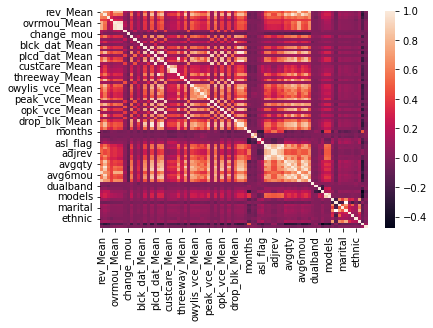

In [385]:
sns.heatmap(corr_matrix)

In [386]:
corr_matrix = without_obj_feat_df.corr(method='pearson')
taget_corrs = corr_matrix.loc[corr_matrix.index == 'churn']
taget_corrs_df = pd.DataFrame(index = taget_corrs.columns)
taget_corrs_df['pearson_value'] = list(taget_corrs.iloc[0])
taget_corrs_df.sort_values('pearson_value')
taget_corrs_df

,pearson_value
rev_Mean,-0.010883
mou_Mean,-0.057027
totmrc_Mean,-0.068558
da_Mean,-0.013551
ovrmou_Mean,0.019720
...,...
dwllsize,0.011326
ethnic,0.025067
creditcd,0.013090
eqpdays,0.112691


#### Как видно, значимых корреляций по Пирсону с таргетом нет

#### Позже при помощи catboost планирую оценить важность фичей для предсказательной модели и на основе этого отобрать признаки

# Подготовка данных для обучения CatBoostClassifier
#### Градиентный бустинг на деревьях решений

In [330]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from catboost import Pool, cv

In [387]:
catboost_df = without_obj_feat_df.copy()

In [410]:
cat_features_catboost = []
k = 0
for i in catboost_df.columns:
    if catboost_df[i].nunique() < (len(catboost_df) - catboost_df[i].isna().sum()) / 100\
    and i.lower().find('mean') == -1 and i != 'churn':
        cat_features_catboost.append(k)
        catboost_df[i] = catboost_df[i].apply(str)
    k+=1

In [411]:
X_train, X_test, y_train, y_test = \
train_test_split(catboost_df.drop('churn', axis=1), catboost_df.churn,\
                 test_size=0.2, random_state=23)

In [391]:
cv_dataset = Pool(data=catboost_df.drop('churn', axis=1),
                  label=catboost_df.churn,
                  cat_features=cat_features_catboost)

## Обучение CatBoostClassifier, сознательно малое количество итераций, модель недообучена, но за метриками мы не гонимся.
#### Обучаем по logloss, тк в случае бинарной классификации - эта функкция ошибка позволяет получить максимальный профит

In [402]:
params = {"iterations": 100,
          "learning_rate":0.01,
          "loss_function": "Logloss",
          "custom_loss" : "Accuracy",
          "verbose": False}

#### Посмотрим на значения на кросс-валидации и затем запустим обучение

In [403]:
scores = cv(cv_dataset,
            params,
            fold_count=5, 
            plot="True")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [405]:
model = CatBoostClassifier(
    iterations=200,
    learning_rate=0.01,
    loss_function='Logloss',
    #eval_metric='F1',
    custom_loss=['AUC','Accuracy','F1'],
    early_stopping_rounds=1000,
)

In [412]:
model.fit(
    X_train, y_train,
    cat_features=cat_features_catboost,
    eval_set=(X_test, y_test),
    verbose=False,
    plot=True,
    #snapshot_file='/Users/artemarhipov/Downloads/model'
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

#### Посмотрим на важность фичей для нашей модели

In [428]:
feature_importances = {}
for i in range(X_train.shape[1]):
    feature_importances[model.feature_importances_[i]] = X_train.columns[i]

#### Посмотрим на распределение важности фичей

<AxesSubplot:>

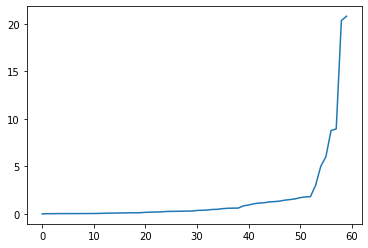

In [435]:
pd.Series(sorted(feature_importances.keys())).plot()

### После обучения градиентного бустинга catboost заметили, что почти 70% всей информации приходится на признаки: eqpdays, months, change_mou, mou_Mean, hnd_price, totmrc_Mean, uniqsubs

In [436]:
sorted(feature_importances.items())[-10:]

[(1.7100512098471332, 'mou_cvce_Mean'),
 (1.7948138512390457, 'crclscod'),
 (1.8166349389374887, 'ovrrev_Mean'),
 (3.008337773479091, 'uniqsubs'),
 (4.999200081223082, 'totmrc_Mean'),
 (6.028615253309432, 'hnd_price'),
 (8.786379414740724, 'mou_Mean'),
 (8.95408604638024, 'change_mou'),
 (20.363307954406743, 'months'),
 (20.815456928878852, 'eqpdays')]

# Обучение по методу К-ближайших соседей

#### На практике не следует выкидывать пустые данные, как минимум потому, что теряется огромнейшая часть наблюдений. Следовало бы заполнить пропуски на худой конец средними наблюдениями по столбцам или по целевым классам. К сожалению я не успел провести подробный анализ и для демонстрации работы с алгаритмами в sklearn просто отброшу записи с пустыми наблюдениями. Хотя тот же catboost хорошо работает как с пропущенными значениями, так и со строковыми типами данных, что не умеют другие представленные тут алгоритмы

In [438]:
from sklearn.neighbors import KNeighborsClassifier

In [442]:
knn_df = without_obj_feat_df.dropna()

In [443]:
X_train, X_test, y_train, y_test = \
train_test_split(knn_df.drop('churn', axis=1), knn_df.churn,\
                 test_size=0.2, random_state=23)

In [446]:
knn = KNeighborsClassifier(n_neighbors=100, n_jobs=-1)

In [447]:
knn.fit(X_train, y_train)

KNeighborsClassifier(n_jobs=-1, n_neighbors=100)

#### Стоит разбивать данные на 3 датасета (тренировочный, валидационный(роль которого в моем ноутбуке играет тестовый) и тестовый)

#### Валидационный предназначается для максимизации на нем функции потерь, а тестовый подается в модель лишь раз, для оценки уже обученной модели. В противном случае мы получим необъективные результаты итогового качества классификации из-за переобучения на тестовой выборке.

#### В наших условиях, мы не пытаемся побить значения метрик, поэтому  шаг создания тестового набора для итоговой проверки качества модели я пропустил

In [450]:
from sklearn.metrics import accuracy_score

In [452]:
accuracy_score(y_test, knn.predict(X_test))

0.5571130331046824

#### Отметим, что алгоритм К-ближайших демонстрирует большее время работы и обучения, чем бустинг catboost, а также его применение невозможно из-за некоторых специфик распределения входных данных. Вернее применение возможно, однако точность классификации будет низкой

# Обучение Random Forest

In [453]:
from sklearn.ensemble import RandomForestClassifier

In [457]:
forest = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=10, min_samples_split=10, \
                                min_samples_leaf=5, verbose=1, n_jobs=-1)

In [458]:
forest.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.4s finished


RandomForestClassifier(max_depth=10, min_samples_leaf=5, min_samples_split=10,
                       n_jobs=-1, verbose=1)

In [459]:
accuracy_score(y_test, forest.predict(X_test))

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished


0.6180286310766477

<AxesSubplot:>

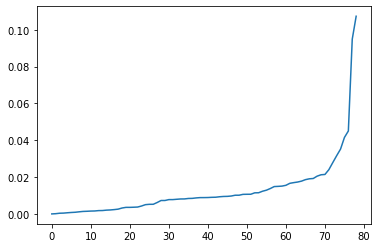

In [464]:
pd.Series(sorted(forest.feature_importances_)).plot()

In [462]:
sorted(forest.feature_importances_)[-10:]

[0.021251517180977997,
 0.021421187520075092,
 0.02400362716655486,
 0.027831226382302402,
 0.03159805199128654,
 0.035203386387699896,
 0.041522868068465134,
 0.045026596553470306,
 0.0948944822880829,
 0.10731277689621749]

#### Как видим лес не смог выделить некоторые фичи, как наиболее полезные, в отличии от catboost, однако получили схожее качество классификации на сырых (не настроенных) алгоритмах.

# Выводы
#### 1. Обчены алгоритмы: градиентный бустинг на деревьях решений catboost, random forest, метод к-ближайших
#### 2. После визуального и микро стат. анализа не удалось выявить видимые корреляции целевого признака с остальными.
#### 3. Были выбраны 79/100 признаков для обучения моделей по стат. тесту Крускела. На практике стоило бы сравнить скорость работы и качество классификации алгоритмов при использовании всех признаков и только признаков отобранных с помощью стат. теста
#### 4. При помощи catboost были выделены признаки eqpdays, months, change_mou, mou_Mean, hnd_price, totmrc_Mean, uniqsubs, несущие в себе более 70% полезной для catboost информации.
#### 5. Для дальнейшего улучшения качества классификации стоило бы попробовать сгененрировать новые признаки с использованием выделенных в п. 4 признаков (перемножить, посмотреть на разности, возвести в степень и т.п.)
#### 6. При обучении алгоритмов из sklearn были отброшены все строки, содержащие пустые значения. Так делать некорректно в абсолютном большинстве случаев. Пути решения проблемы были описаны выше в ноутбуке но не реализованы, из-за отсутствия времени(

## Автор: Архипов Артем Сергеевич